## Plot puv fluxes (baroclinic and barotropic energy)
adapted from Fluxes_subdomains_old.ipynb and plot_BclinNRJdiag.ipynb

Plot snapshots of, e.g. low-pass filtered fields or avg.

Store values per subdomain in a json file

Not for animation, so I load every fields

In [2]:
%matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
#plt.rcParams['text.usetex'] = True
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset, MFDataset
import numpy as np
#import gsw
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageDraw
import json

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"

In [2]:
simul = 'luckym2'
what = "ekint"
dostrflu = False # stream plot of baroclinic flux
dosqflu = True # quiver (by-passed by dostrflu if the latter is True)

path_base = KRYPTON + 'DIAG/NRJ_fluxes/'
fil_iflux = path_base+simul+'_bclnrj_M2.?.nc'
fil_sflux = path_base+simul+'_btrnrj.?.nc'
fil_grd = KRYPTON + 'lucky_corgrd.nc'
st = 2  #ncr.subsamp_step
pm, pn = (1/(st*750),)*2 # a la main but should be read in file for more generality

units = {"ekint":r"kJ/m$^2$", "flux":r"kw/m", "cterm":r"W/m$^2$",
        "divf":r"W/m$^2$", "dissip":r"W/m$^2$"}
vnam = {key:key for key in ["ekint", "flux", "cterm", "divf", "dissip"]}
vnam["cterm"] = r"$C_t$"
vnam["ekint"] = r"$E_k$"

#plotting parameters
dirpic = './pictures/bclin_fluxes/'
dosavefig = False

# plotting parameters
fs       = 12
proj     = 'lcc'
brs      = 'i'
stride   = 5
Lx,Ly    = 1500e3, 1500e3 #2*2*30*1852*np.array([1,1]) # extend in m
cmap = plt.get_cmap('gist_stern_r')  #
zlevs = [0,1000,2000,3500]
topocol = 'k'     # isobath. contour color
grdcol = 'gray'   # grid color

xm, ym = None, None #-32.28, 37.3

rlevs = None

In [9]:
# Load data: grid & topo & subdomains
doploth = True  # plot topo 

ncg = Dataset(fil_grd,'r')
slix = slice(1,2000,st)
sliy = slice(1,2000,st)
fcor = ncg.variables['f'][sliy,:][:,slix]
lon = ncg.variables['lon_rho'][sliy,:][:,slix]
lat = ncg.variables['lat_rho'][sliy,:][:,slix]
dx = .5*(np.mean(1./ncg.variables['pm'][:]) + np.mean(1./ncg.variables['pn'][:]) ) * st
Ny, Nx = lon.shape
if xm is not None:
    jm, im = np.unravel_index( ((lon-xm)**2 + (lat-ym)**2).argmin(), (Ny,Nx) )
    j1, j2 = jm + np.array([-1,1])*int(Lx/dx/2.)
    i1, i2 = im + np.array([-1,1])*int(Ly/dx/2.)
    print("jjs, iis:",j1,j2,i1,i2, "from parent: X",st)
else:
    j1, j2, i1, i2 = 0, Ny, 0, Nx
topo = ncg.variables['h'][sliy,:][:,slix][j1:j2,i1:i2]
lon = lon[j1:j2,i1:i2]
lat = lat[j1:j2,i1:i2]
print("loaded grid")

# load subdomains
with open("subdomains_lucky.json", "r") as fp:
    mydoms = json.load(fp)

print("min/max lon, lat:", lon.min(), lon.max(), lat.min(), lat.max())

# local routines
def coord_to_pix(pos, lon=lon, lat=lat):
    return np.unravel_index(((lon-pos[0])**2+(lat-pos[1])**2).argmin(), lon.shape)[::-1]

def poly_to_mask(poly,shape):
    img = Image.new('1',shape)
    ImageDraw.Draw(img).polygon(poly, outline=1, fill=1)
    return np.array(img)

def polycoord_tomask(coord,lon,lat):
    poly = [coord_to_pix(item) for item in coord]
    return poly_to_mask(poly,lon.shape)

def get_domean(field, dom, lon=lon, lat=lat, masksup=(topo>100)):
    mask = polycoord_tomask(dom, lon, lat)
    if masksup is not None: mask *= masksup
    return np.nanmean(field[...,mask], axis=(-1))

loaded grid
min/max lon, lat: -41.8086236619 -23.2006244309 30.4960379447 44.2189371832


<IPython.core.display.Javascript object>


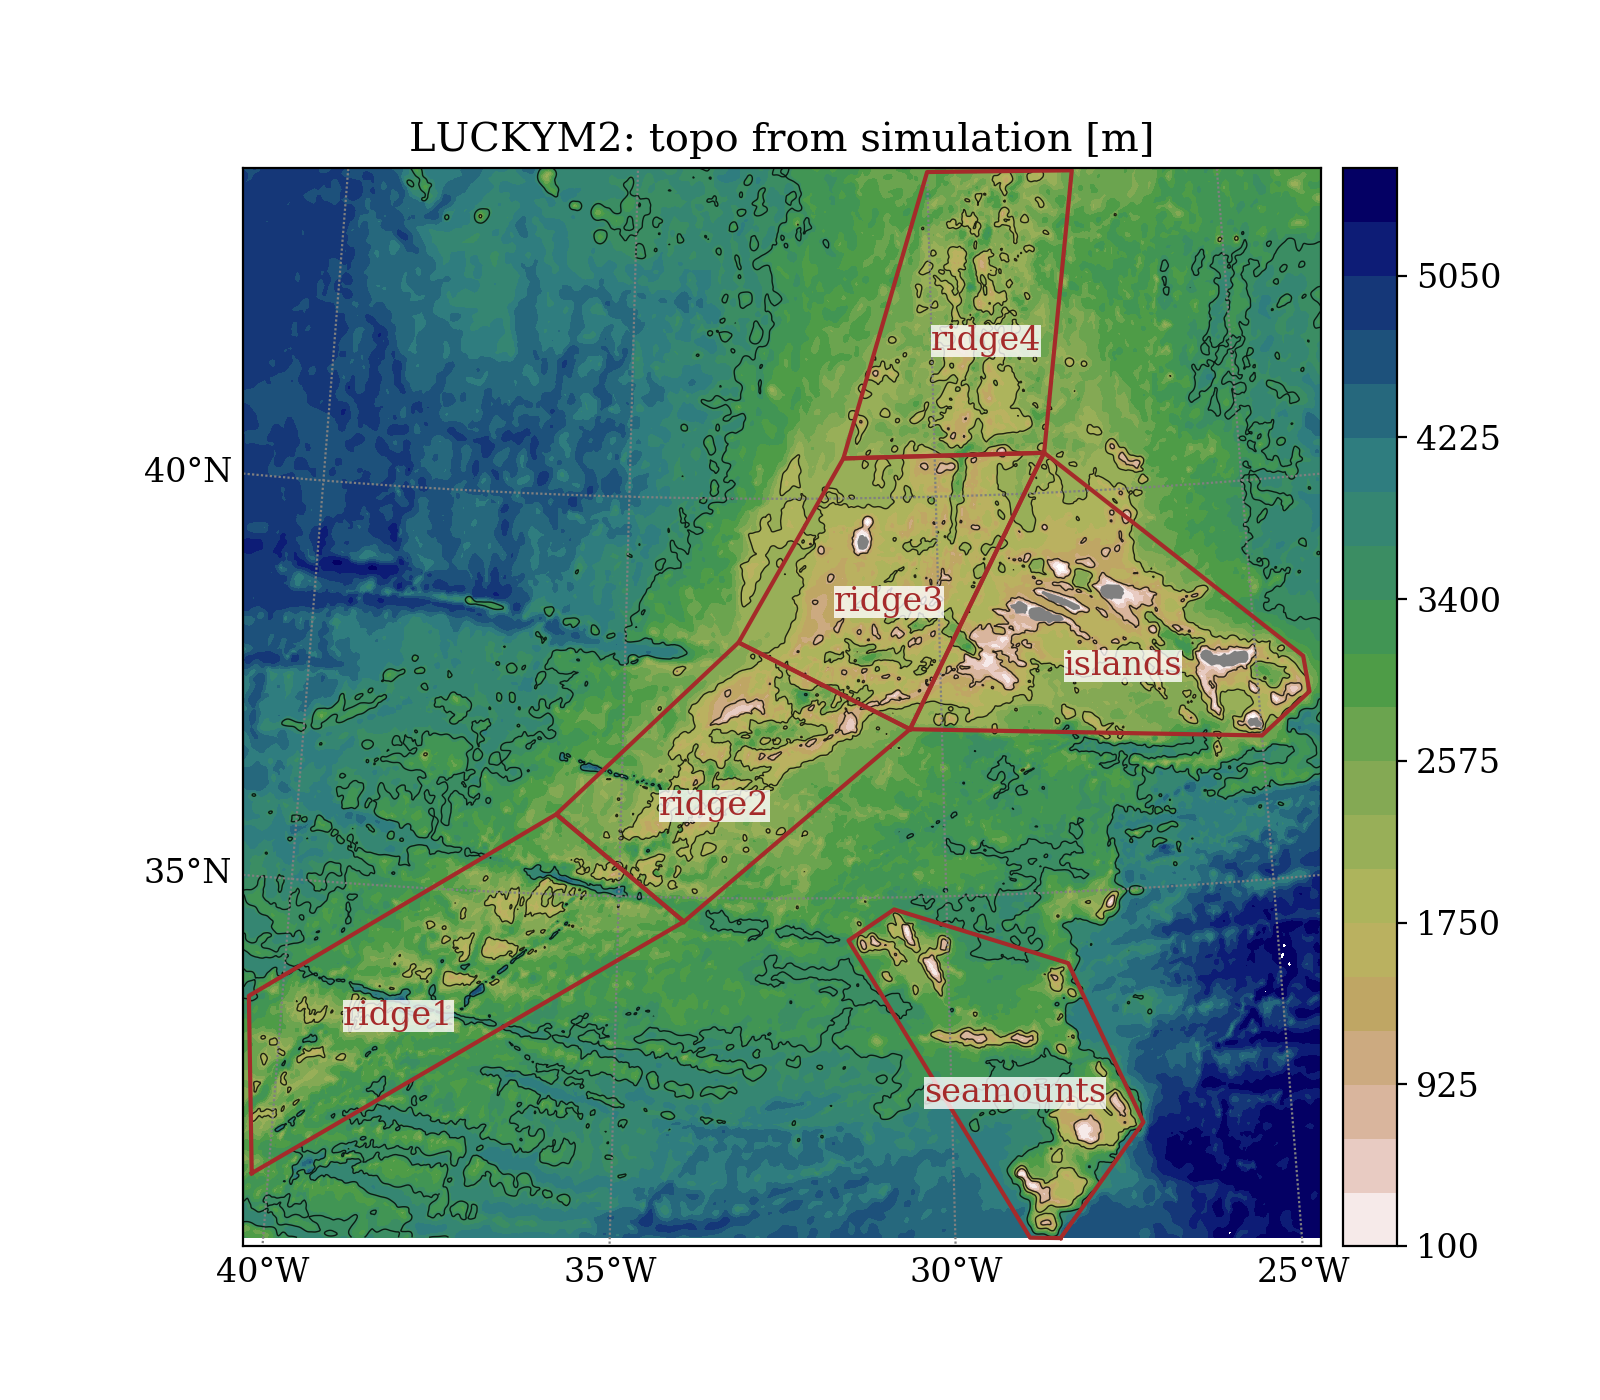

In [79]:
# plot it
do_subdom = True

vmin, vmax = round(topo.min()+50,-2), round(topo.max()-50,-2)
levs = np.linspace(vmin, vmax, 21)
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=brs,lon_0=lon.mean(),\
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contourf(xx, yy, topo, levels=levs, cmap="gist_earth_r")
hcb = bm.colorbar(hct)
for item in hct.collections:
    item.set_rasterized(True)
hct = bm.contour(xx, yy, topo, levels=zlevs, colors=topocol, linewidths=0.5, alpha=0.8)
for item in hct.collections:
    item.set_rasterized(True)

if do_subdom:
    for key,val in mydoms.items():
        if key == "ridges":
            for ido,dom in enumerate(val):
                x, y = bm(*np.array(dom).T.take(range(len(dom)+1),axis=1,mode='wrap'))
                bm.plot(x, y, color="brown")
                ax.text(x.mean(), y.mean(), key.rstrip('s')+str(ido+1), color="brown", ha="center", va="center", 
                    bbox=dict(facecolor="white", alpha=.8, edgecolor="none", pad=.02))

        else:
            x, y = bm(*np.array(val).T.take(range(len(val)+1),axis=1,mode='wrap'))
            bm.plot(x, y, color="brown")
            ax.text(x.mean(), y.mean(), key, color="brown", ha="center", va="center", 
                    bbox=dict(facecolor="white", alpha=.8, edgecolor="none", pad=.02))

plt.title(simul.upper()+": topo from simulation [m]")

if dosavefig:
    fig.savefig(dirpic+simul+"_topo.pdf", magnification="auto", bboxçinches="tight", dpi=150)

In [4]:
suf = "_lf"
it = 100 #182 #436 #182 #    
    
# load data
print("loading", end="... ")
ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
var = "ekint"
print(var, end=", ")
ekavg = ncbc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
ekint = ncbc.variables[var+suf][j1:j2,...][:,i1:i2,...][...,it]
var = "epint"
print(var, end=", ")
epavg = ncbc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
epint = ncbc.variables[var+suf][j1:j2,...][:,i1:i2,...][...,it]

print("bclin fluxes", end=", ")
fxavg = ncbc.variables["puint"+"_avg"][j1:j2,...][:,i1:i2,...]
fyavg = ncbc.variables["pvint"+"_avg"][j1:j2,...][:,i1:i2,...]
fxbc = ncbc.variables["puint"+suf][j1:j2,...][:,i1:i2,...][...,it]
fybc = ncbc.variables["pvint"+suf][j1:j2,...][:,i1:i2,...][...,it]

ncbc.close()

print("Cterm")
ncbt = MFDataset(fil_sflux,aggdim='eta_rho')
ctavg = ncbt.variables["Ct_avg"][j1:j2,...][:,i1:i2,...]
cterm = ncbt.variables["Ct"+suf][j1:j2,...][:,i1:i2,...][...,it]
ncbt.close()

# compute div flux
dfav = (np.gradient(fxavg, axis=1)/dx + np.gradient(fyavg, axis=0)/dx)*1e3
divf = (np.gradient(fxbc, axis=1)/dx + np.gradient(fybc, axis=0)/dx)*1e3

diav = ctavg - dfav
diss = cterm - divf

loading... ekint, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


epint, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


bclin fluxes, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


Cterm


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


In [7]:
nc = MFDataset(fil_iflux,aggdim='eta_rho')
ep_lf = nc.variables['epint_lf'][:].mean(axis=(1,2))
ek_lf = nc.variables['ekint_lf'][:].mean(axis=(1,2))
ncbc.close()


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


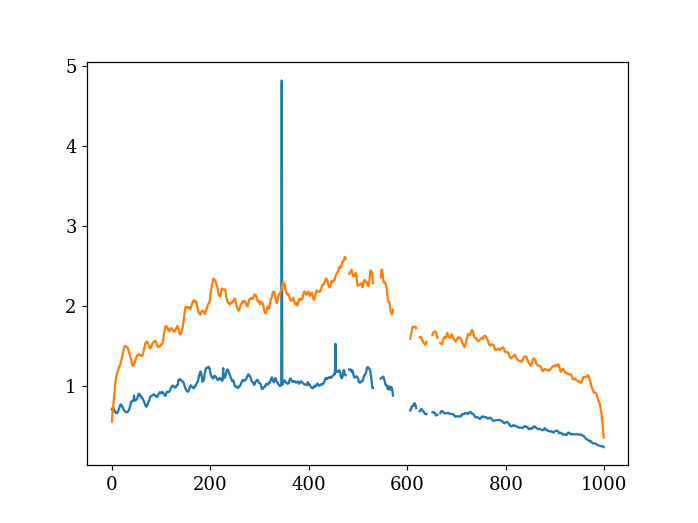

<IPython.core.display.Javascript object>


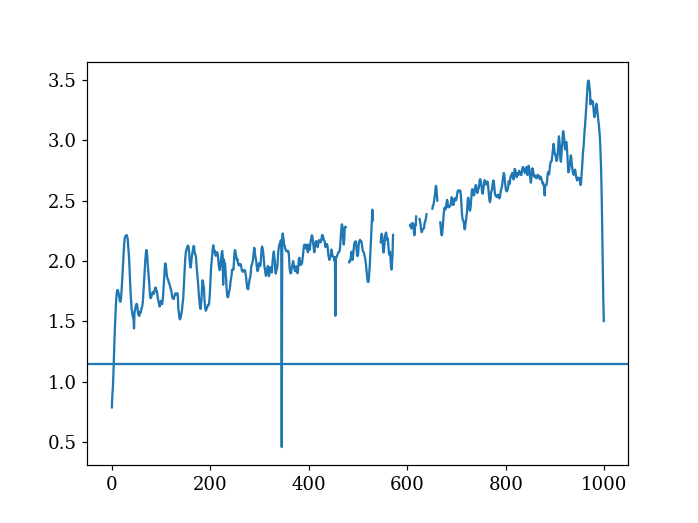

In [10]:
plt.figure()
plt.plot(ep_lf)
plt.plot(ek_lf)

om = 2*np.pi/(12.42*3600)
f0 = fcor.mean()

plt.figure()
plt.plot(ek_lf/ep_lf)
plt.axhline((om**2+f0**2)/2/(om**2-f0**2))

<IPython.core.display.Javascript object>


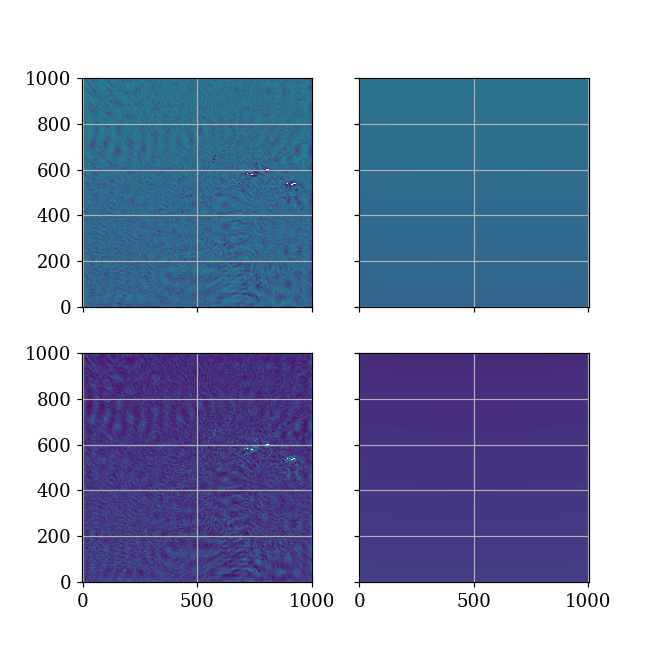

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


1.14820236125 0.681454
0.681719 0.698178626163
0.318281 0.301821373837
2.50323 2.35882021629


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [28]:
om = 2*np.pi/(12.42*3600)
f0 = fcor.mean()
rat_ek = (om**2+fcor**2)/(2.*om**2)
rat_ep = (om**2-fcor**2)/(2.*om**2)
rat_kp = (om**2+fcor**2)/(om**2-fcor**2)

etot = ekint+epint

fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(6,6))
axs[0,0].pcolormesh(ekint/etot, vmin=0, vmax=2)
axs[1,0].pcolormesh(epint/etot, vmin=0, vmax=2)
axs[0,1].pcolormesh(rat_ek, vmin=0, vmax=2)
axs[1,1].pcolormesh(rat_ep, vmin=0, vmax=2)


for ax in axs.ravel():
    ax.set_aspect(1)
    ax.grid(True)
    
print(rat_th, np.nanmean((ekint/(ekint+epint))))

mask = topo>300

print((ekint/etot)[mask].mean(), rat_ek[mask].mean())
print((epint/etot)[mask].mean(), rat_ep[mask].mean())
print((ekint/epint)[mask].mean(), rat_kp[mask].mean())

<IPython.core.display.Javascript object>


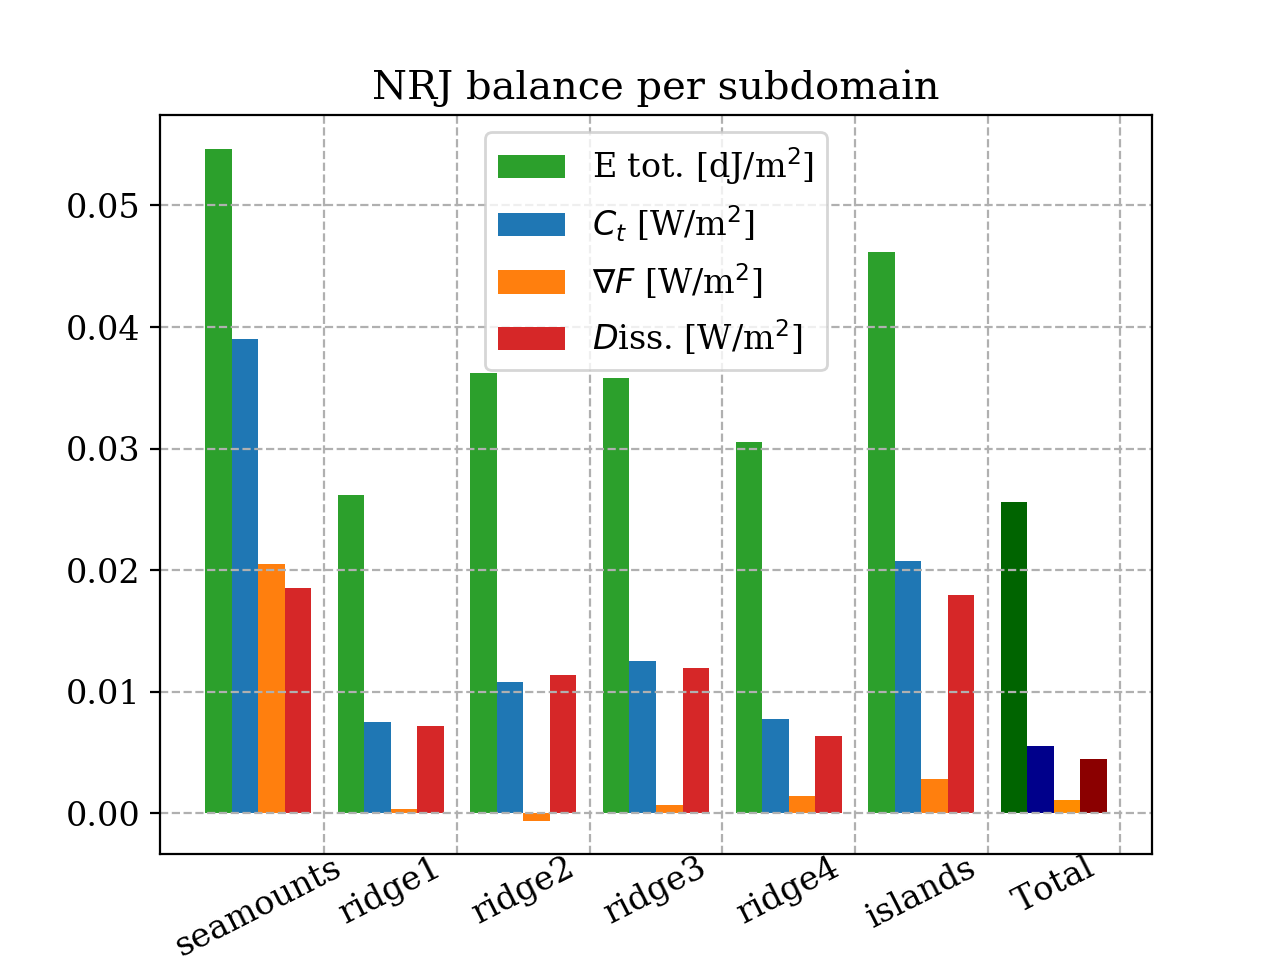

seamounts
TE_moy 5.46647
Ct_moy 0.0389776
divf_moy 0.0204881
diss_moy 0.0184895
ridge1
TE_moy 2.62096
Ct_moy 0.00751525
divf_moy 0.000305696
diss_moy 0.00720956
ridge2
TE_moy 3.62508
Ct_moy 0.0107568
divf_moy -0.000629146
diss_moy 0.011386
ridge3
TE_moy 3.5777
Ct_moy 0.0125512
divf_moy 0.000642664
diss_moy 0.0119121
ridge4
TE_moy 3.05409
Ct_moy 0.0077101
divf_moy 0.00139737
diss_moy 0.00631272
islands
TE_moy 4.61372
Ct_moy 0.020724
divf_moy 0.00280449
diss_moy 0.0179466
full
TE_moy 2.56197
Ct_moy 0.00556613
divf_moy 0.00112079
diss_moy 0.00446242


In [61]:
# Apply masks and compute values in subdomains

# First: unfold subdomains
doms, nams = [], []
for key,val in mydoms.items():
    if key == "ridges":
        for ido,dom in enumerate(val):
            doms.append(dom)
            nams.append(key.rstrip("s")+str(ido+1))
    else:
        doms.append(val)
        nams.append(key)
        
# COmpute mean and totals over subdomains. N.B.: not OK for non-uniform grid
res = {}
for dom,nam in zip(doms,nams):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ras = {"size":((1/pm/pn)*(mask*1)).sum(), 'coords':dom}
    ektot = (ekavg/pm/pn)[mask].sum()
    ras["KE_moy"] = np.nanmean((ekavg)[mask])
    ras["KE_tot"] = np.nansum((ekavg/pm/pn)[mask])
    ras["PE_moy"] = np.nanmean((epavg)[mask])
    ras["PE_tot"] = np.nansum((epavg/pm/pn)[mask])
    ras["TE_moy"] = np.nanmean(((ekavg+epavg))[mask])
    ras["TE_tot"] = np.nansum(((ekavg+epavg)/pm/pn)[mask])
    ras["divf_moy"] = np.nanmean((dfav)[mask])
    ras["divf_tot"] = np.nansum((dfav/pm/pn)[mask])
    ras["Ct_moy"] = np.nanmean((ctavg)[mask])
    ras["Ct_tot"] = np.nansum((ctavg/pm/pn)[mask])
    ras["diss_moy"] = np.nanmean((diav)[mask])
    ras["diss_tot"] = np.nansum((diav/pm/pn)[mask])
    res[nam] = ras
TE_moy = np.nanmean(ekavg+epavg)
Ct_moy = np.nanmean(ctavg)
diss_moy = np.nanmean(diav)
divf_moy = np.nanmean(divf)
    
# Plot it 
ind = np.arange(len(res)+1)
fields = ['TE_moy','Ct_moy','divf_moy','diss_moy']
cols = ['tab:green','tab:blue','tab:orange','tab:red']
labs = [r'E tot. [dJ/m$^2$]', r"$C_t$ [W/m$^2$]", r"$\nabla F$ [W/m$^2$]", r"$D$iss. [W/m$^2$]"]
facts = [1e-2, 1, 1, 1]
width = .8

fig = plt.figure()
ax = plt.subplot(111)
for ina,nam in enumerate(nams):
    print(nam)
    for ifi,fie in enumerate(fields):
        lab = labs[ifi] if ina==0 else None
        ax.bar(ind[ina]-width/2+width*(ifi+.5)/len(fields), res[nam][fie]*facts[ifi], width/len(fields), 
               color=cols[ifi], label=lab)
        print(fie, res[nam][fie])
print("full")
for ifi,fie in enumerate(fields):
    ax.bar(ind[-1]-width/2+width*(ifi+.5)/len(fields), eval(fie)*facts[ifi], width/len(fields), 
        color=cols[ifi].replace("tab:","dark"))
    print(fie, eval(fie))

ax.set_xticks(ind)
ax.set_xticklabels(nams+['Total'], rotation=27, y=.03, ha="center")
ax.set_xticks(ind+.5,minor=True)
ax.grid(which="major", axis="x", linestyle="none")
ax.grid(which="minor", axis="x", linestyle="--")
ax.tick_params(bottom=False, which="both")
ax.grid(axis="y", linestyle="--")

plt.legend()
plt.title("NRJ balance per subdomain")

fig.savefig("pictures/slides/NRJ_balance_bclin_alldoms.pdf", magnification="auto", bbox_inches="tight")

## Snapshots

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


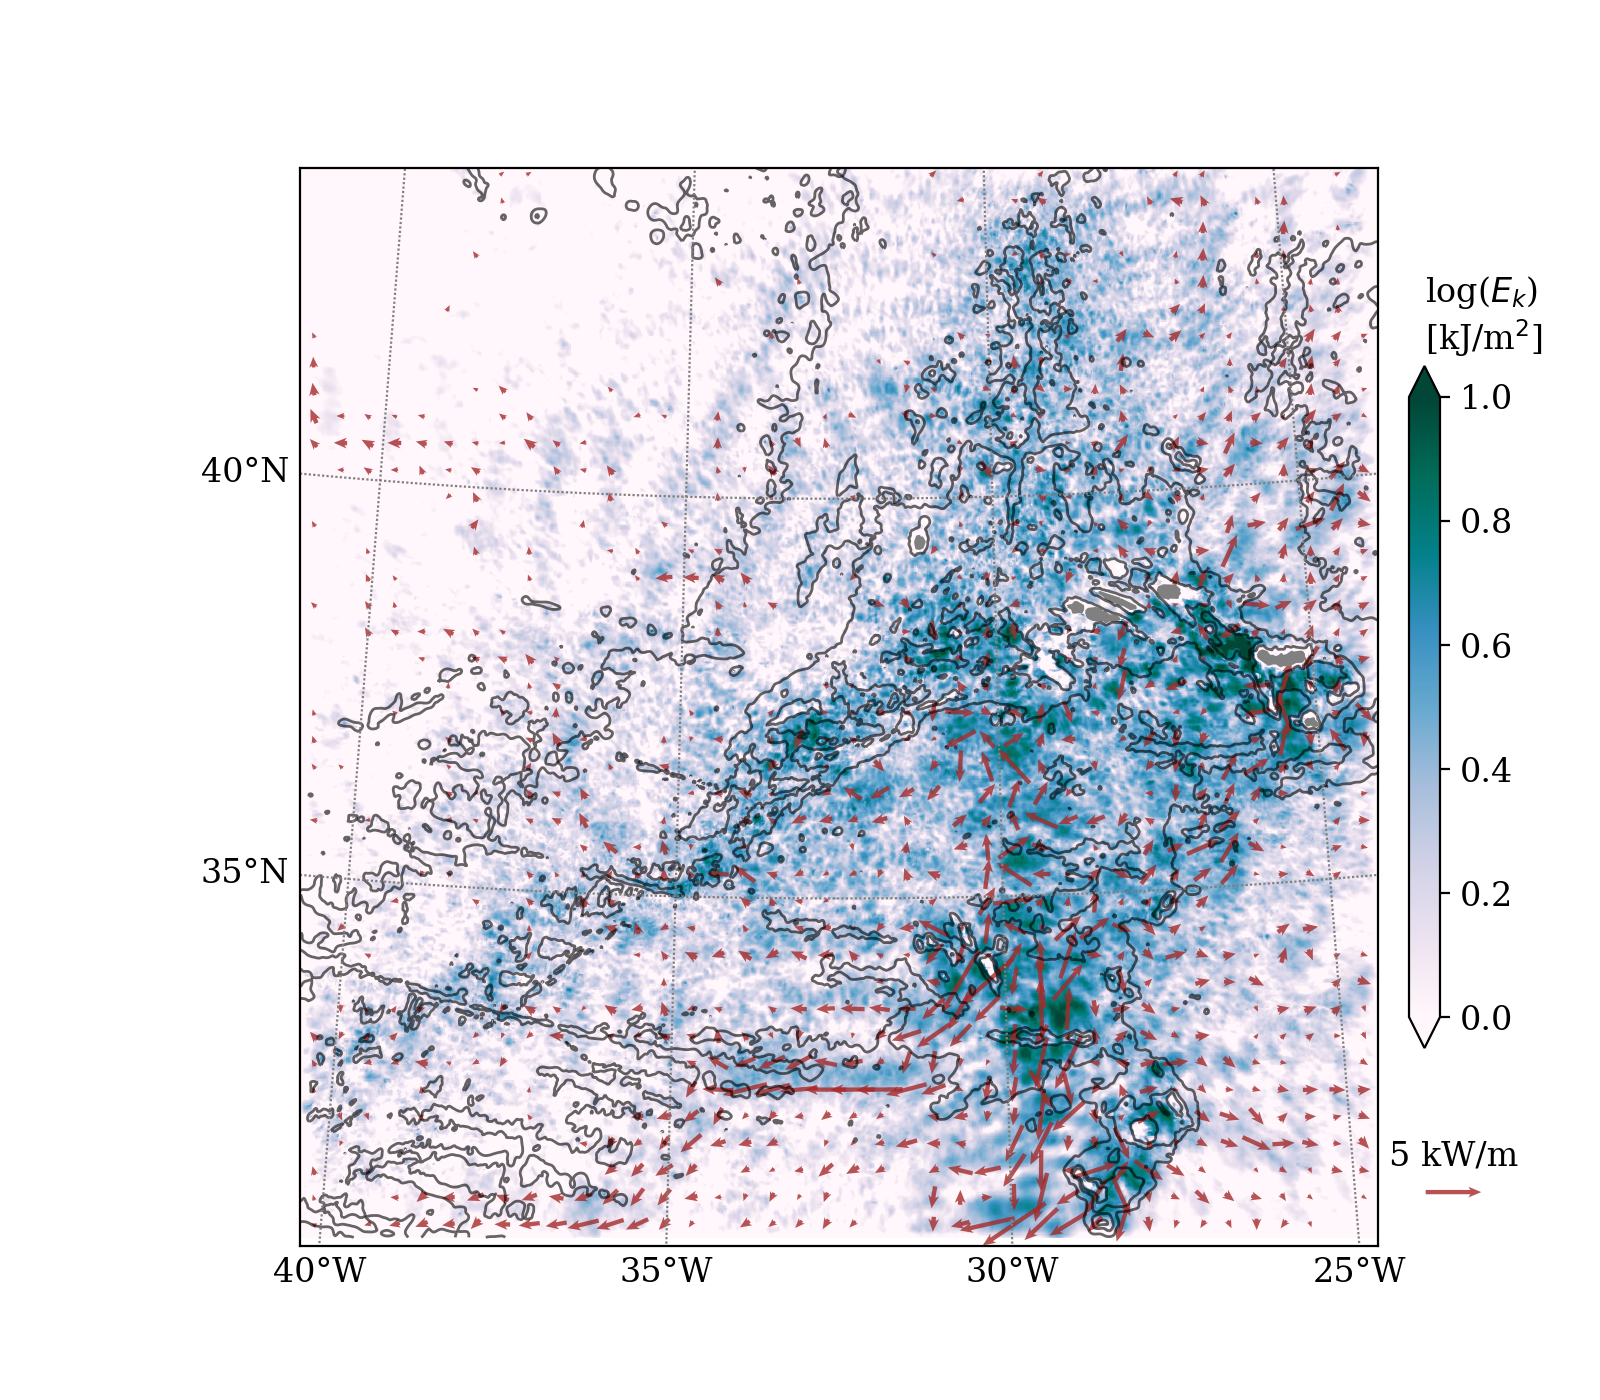

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less


In [68]:
# plot data: ekint + flux
mysc = "log" # "log" # "linear"
cmap = "PuBuGn"
topocol = "k"
usc = 18
usq = 5
nsq = 25
color = "brown"
what = "ekint"
do_plotsubdom = False

toplot = ekint
    
if mysc == "linear":
    vmin, vmax = 0, ekavg.mean() + 5*ekavg.std() 
elif mysc == "log":
    toplot = np.log10(toplot)
    vmax = 1 #np.nanmax(np.log10(davg))
    vmin = 0 #vmax - 1.5
    
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=brs,lon_0=lon.mean(),\
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
for item in hct.collections:
    item.set_rasterized(True)

hpc = bm.pcolormesh(xx, yy, toplot, vmin=vmin, vmax=vmax, cmap=cmap)
hcb = plt.colorbar(hpc, fraction=.025, extend="both", pad=.025)
hcb.formatter.set_powerlimits((-1, 1))
hcb.update_ticks()
hcb.ax.tick_params(labelsize=fs)
if mysc == "log":
    bartit = mysc+"({0})    \n[{1}]    ".format(vnam[what],units[what])
else:
    bartit = "{0}    \n[{1}]    ".format(vnam[what],units[what])
hcb.ax.set_title(bartit, fontsize=fs, ha="left")

#bm.drawmapscale(lonm.mean() - .8*(lonm.max()-lonm.min())/2, latm.mean() + .9*(latm.max()-latm.min())/2, lonm.mean() \
#                ,latm.mean(), length=200, units="km", style="fancy")

if dostrflu:
    speed = np.sqrt(fxbc**2 + fybc**2)
    lw = .1 + 4*speed / np.nanmax(speed) # Line Widths
    hqv = bm.streamplot(xx.mean(axis=0), yy.mean(axis=1), fxbc, fybc \
                        , density=5, color=color, linewidth=lw)
elif dosqflu:
    slix, sliy = slice(nsq//2,Nx,nsq), slice(nsq//2,Ny,nsq)
    fxpl, fypl = fxbc[sliy,slix], fybc[sliy,slix]
    mask = np.sqrt(fxpl**2 + fypl**2)<.5
    hqb = bm.quiver(xx[sliy,slix], yy[sliy,slix], np.ma.masked_where(mask, fxpl) \
                    , np.ma.masked_where(mask, fypl), scale=usc, scale_units="inches" \
              , color='brown', pivot="mid", angles="xy", width=4e-3 \
                    , headlength=3, headwidth=2.5, headaxislength=2.5, alpha=.8)
    hqk = ax.quiverkey(hqb, X=1.07, Y=.05, U=usq \
                       , label=r'{} kW/m'.format(usq))

if do_plotsubdom:
    for key,val in mydoms.items():
        if key == "ridges":
            for dom in val:
                x, y = bm(*np.array(dom).T.take(range(len(dom)+1),axis=1,mode='wrap'))
                bm.plot(x, y, color="darkorange", lw=1)
        else:
            x, y = bm(*np.array(val).T.take(range(len(val)+1),axis=1,mode='wrap'))
            bm.plot(x, y, color="darkorange", lw=1)

    plt.title(simul+": {0} {1}".format(what,str(it)))

if dosavefig:
    fig.savefig(dirpic+simul+"_{0}_{1}_{2}.png".format(what,str(it),mysc[:3]), magnification='auto' ,dpi=150, bbox_inches="tight")
    

<IPython.core.display.Javascript object>


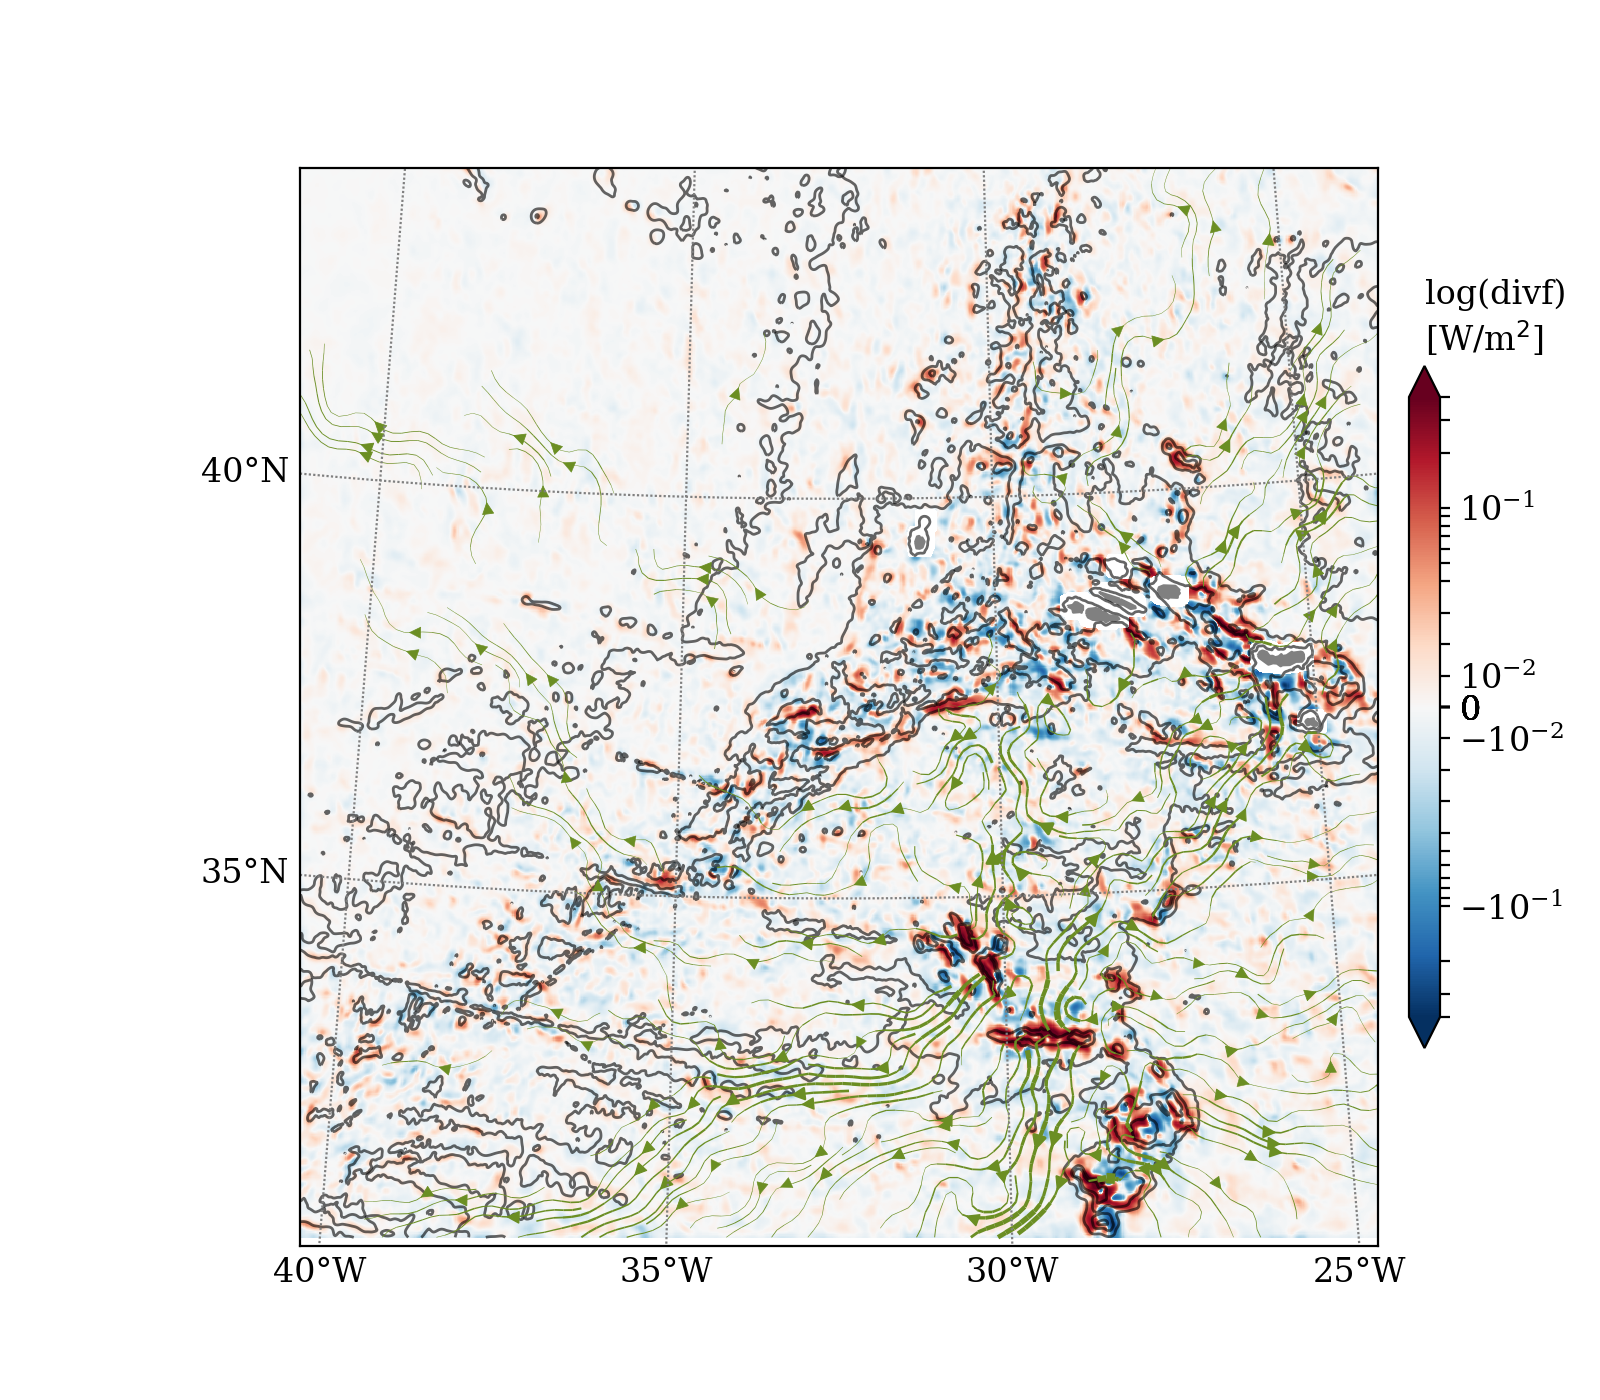

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


In [70]:
# plot: conversion term
mysc = "log" # "log" # "linear"
cmap = "RdBu_r"
topocol = "k"
usq = 5
nsq = 25
color = "olivedrab"
what = "divf"
doblur = True
do_plotsubdom = False

toplot = eval(what)
if doblur:
    toplot = gaussian_filter(toplot, sigma=2, mode="mirror")

if mysc == "lin":
    vmin, vmax = 10*np.nanstd(ctavg) *np.array([-1,1])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
elif mysc == "log":
    vamp = 10*np.nanstd(dfav)
    norm = mpl.colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
    
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=brs,lon_0=lon.mean(),\
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
for item in hct.collections:
    item.set_rasterized(True)

hpc = bm.pcolormesh(xx, yy, toplot, norm=norm, cmap=cmap)
hcb = plt.colorbar(hpc, fraction=.025, extend="both", pad=.025)
hcb.ax.tick_params(labelsize=fs)
if mysc == "log":
    bartit = mysc+"({0})    \n[{1}]    ".format(vnam[what],units[what])
else:
    bartit = "{0}    \n[{1}]    ".format(vnam[what],units[what])
hcb.ax.set_title(bartit, fontsize=fs, ha="left")

#bm.drawmapscale(lonm.mean() - .8*(lonm.max()-lonm.min())/2, latm.mean() + .9*(latm.max()-latm.min())/2, lonm.mean() \
#                ,latm.mean(), length=200, units="km", style="fancy")

if True: # dostrflu:
    speed = np.sqrt(fxbc**2 + fybc**2)
    mask = speed<.5
    lw = 4 * speed / np.nanmax(speed) # Line Widths
    hqv = bm.streamplot(xx.mean(axis=0), yy.mean(axis=1), np.ma.masked_where(mask,fxbc) \
                        , np.ma.masked_where(mask, fybc), density=4, color=color, linewidth=lw)
elif False:#dosqflu:
    slix, sliy = slice(nsq//2,Nx,nsq), slice(nsq//2,Ny,nsq)
    fxpl, fypl = fxbc[sliy,slix], fybc[sliy,slix]
    mask = np.sqrt(fxpl**2 + fypl**2)<.5
    hqb = bm.quiver(xx[sliy,slix], yy[sliy,slix], np.ma.masked_where(mask, fxpl) \
                    , np.ma.masked_where(mask, fypl), scale=17, scale_units="inches" \
              , color='brown', pivot="mid", angles="xy", width=4e-3 \
                    , headlength=3, headwidth=2.5, headaxislength=2.5)
    hqk = ax.quiverkey(hqb, X=1.07, Y=.05, U=usq \
                       , label=r'{} kW/m'.format(usq))
    
if do_plotsubdom:
    for key,val in mydoms.items():
        if key == "ridges":
            for dom in val:
                x, y = bm(*np.array(dom).T.take(range(len(dom)+1),axis=1,mode='wrap'))
                bm.plot(x, y, color="darkorange")
        else:
            x, y = bm(*np.array(val).T.take(range(len(val)+1),axis=1,mode='wrap'))
            bm.plot(x, y, color="darkorange")

    plt.title(simul+": {0} {1}".format(what,str(it)))
    
if dosavefig:
    fig.savefig(dirpic+simul+"_{0}_{1}_{2}.png".format(what,str(it),mysc[:3]), magnification='auto' ,dpi=150, bbox_inches="tight")

<IPython.core.display.Javascript object>


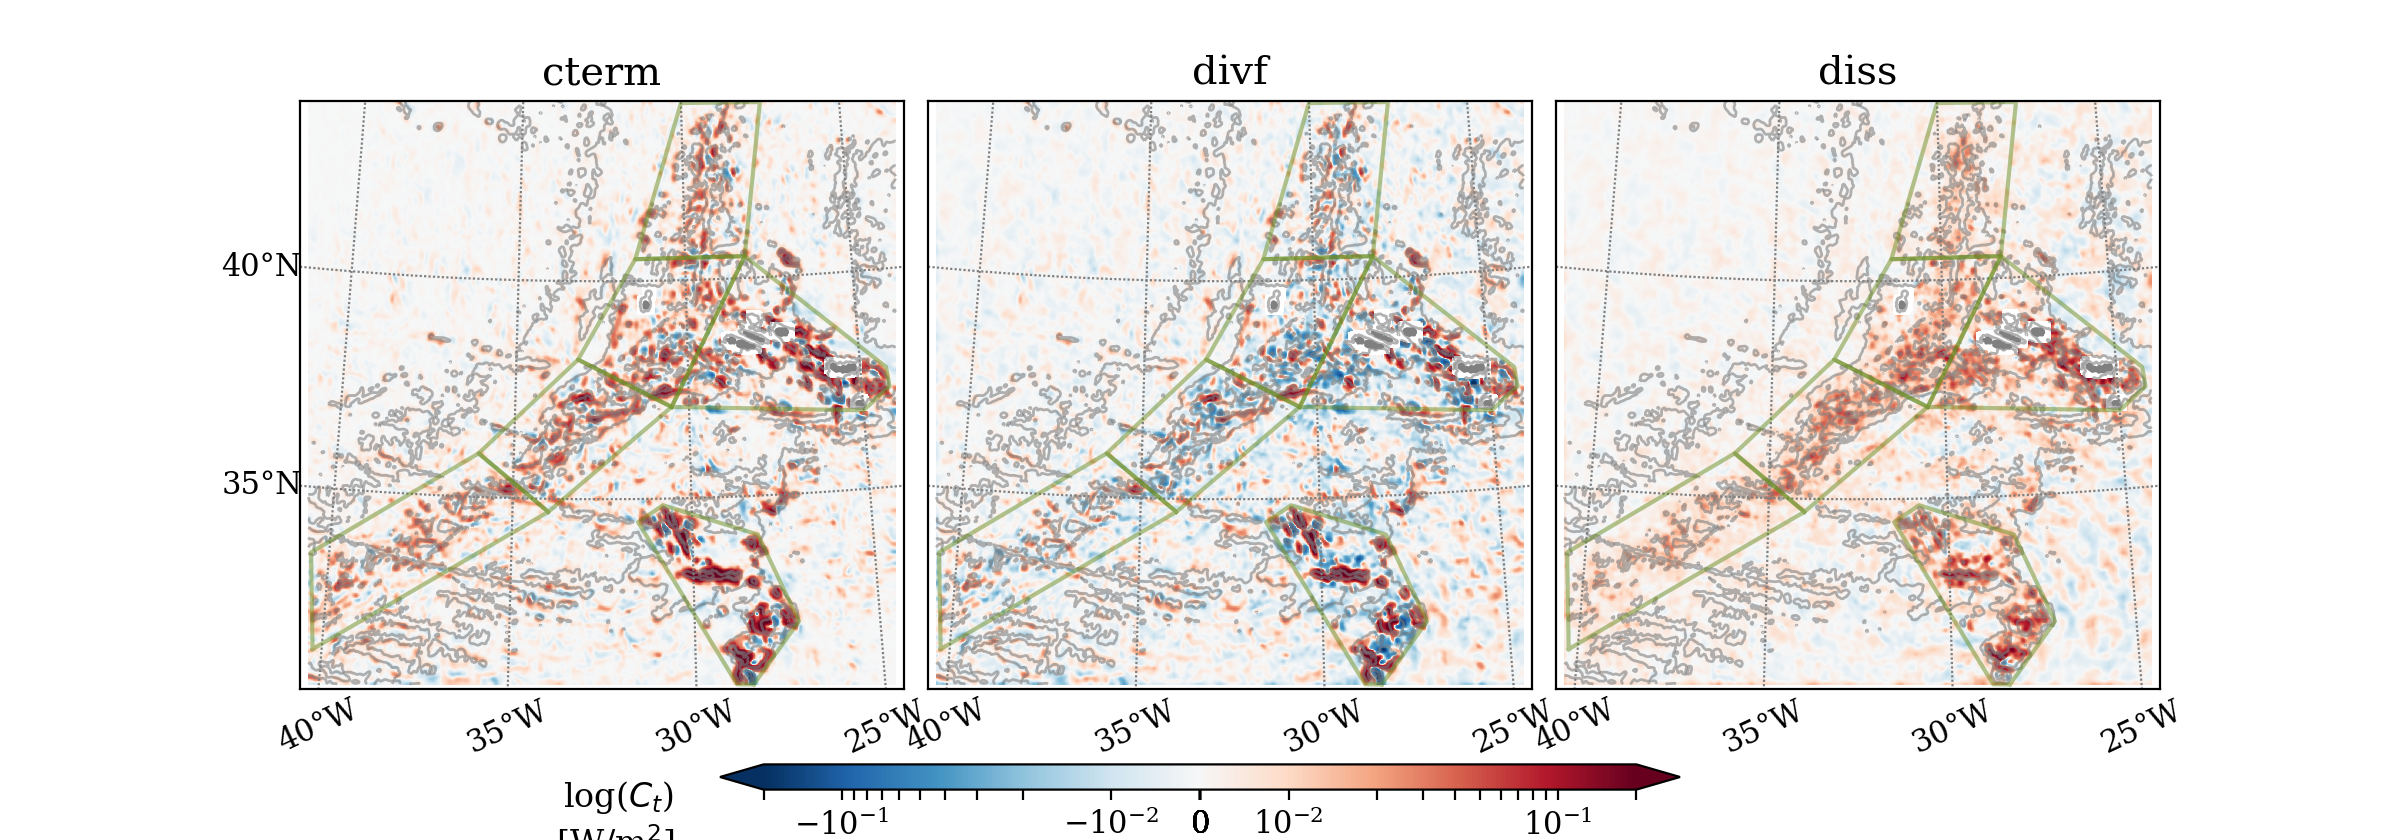

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


In [94]:
# conversion, divergence, dissipation
mysc = "log" # "log" # "linear"
cmap = "RdBu_r"
topocol = "grey"
usq = 5
nsq = 25
color = "olivedrab"
what = ["cterm","divf","diss"]
doblur = True

do_plotsubdom = True

if mysc == "lin":
    vmin, vmax = 5*np.nanstd(ctavg) *np.array([-1,1])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
elif mysc == "log":
    vamp = 5*np.nanstd(dfav)
    norm = mpl.colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
    
fig, axs = plt.subplots(1, len(what), figsize=(len(what)*4,4.2), sharex=True, sharey=True)
for iwa,wha in enumerate(what):
    ax = axs[iwa]
    toplot = eval(wha)
    if doblur:
        toplot = gaussian_filter(toplot, sigma=3, mode="mirror")

    bm = Basemap(projection=proj,resolution=brs,lon_0=lon.mean(),\
            lat_0=lat.mean(),width=Lx,height=Ly, ax=ax)
    xx, yy = bm(lon, lat)
    bm.drawcoastlines(color='gray')
    bm.fillcontinents(color='gray')
    bm.drawparallels(np.arange(-60,70,stride),labels=[int(iwa==0),0,0,0],linewidth=0.8,\
                    fontsize=fs-1,color=grdcol)
    bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                    fontsize=fs-1,color=grdcol, rotation=25)
    hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
    for item in hct.collections:
        item.set_rasterized(True)

    hpc = bm.pcolormesh(xx, yy, toplot, norm=norm, cmap=cmap)
    ax.set_title(wha)
    
    if do_plotsubdom:
        for key,val in mydoms.items():
            if key == "ridges":
                for dom in val:
                    x, y = bm(*np.array(dom).T.take(range(len(dom)+1),axis=1,mode='wrap'))
                    bm.plot(x, y, color=color, alpha=.5)
            else:
                x, y = bm(*np.array(val).T.take(range(len(val)+1),axis=1,mode='wrap'))
                bm.plot(x, y, color=color, alpha=.5)

fig.subplots_adjust(bottom=0.18, wspace=.04)
cbar_ax = fig.add_axes([0.3, 0.06, 0.4, 0.03])
hcb = fig.colorbar(hpc, cax=cbar_ax, orientation="horizontal", extend="both")
hcb.ax.tick_params(labelsize=fs-1)
if mysc == "log":
    bartit = mysc+"({0})    \n[{1}]    ".format(vnam[what[0]],units[what[0]])
else:
    bartit = "{0}    \n[{1}]    ".format(vnam[what],units[what])
hcb.ax.set_ylabel(bartit, fontsize=fs, ha="right", rotation=0, va="top")

if dosavefig:
    fig.savefig(dirpic+simul+"_{0}_{1}_{2}.png".format("-".join(what),str(it),mysc[:3]), magnification='auto' ,dpi=150, bbox_inches="tight")

In [96]:
dirpic

'./pictures/bclin_fluxes/'

## Time evolution
of integrated quantities

In [21]:
# Per subdomain (ct, diss and U_bt only) !
ress = {}

ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
if 'scrum_time' in ncbc.variables:
    times = ncbc.variables['scrum_time'][:]/24
else:
    times = np.arange(Nt)/24.
prov = (np.gradient(ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:], axis=1)/dx \
        + np.gradient(ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:], axis=0)/dx)*1e3
ncbc.close()

for nam,dom in zip(nams,doms):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ress[nam] = {"divf":np.nanmean(prov[mask,:], axis=0)}

# conversion and btrop KE
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")
prov = ncbt.variables['Ct_lf'][j1:j2,:,:][:,i1:i2,:]
ncbt.close()
for nam,dom in zip(nams,doms):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ress[nam]["cterm"] = np.nanmean(prov[mask,:], axis=0)
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")    
prov = np.sqrt(ncbt.variables["ekbt_lf"][j1:j2,:,:][:,i1:i2,:]*2)
ncbt.close()
for nam,dom in zip(nams,doms):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ress[nam]["Ubt"] = np.nanmean(prov[mask,:], axis=0)

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


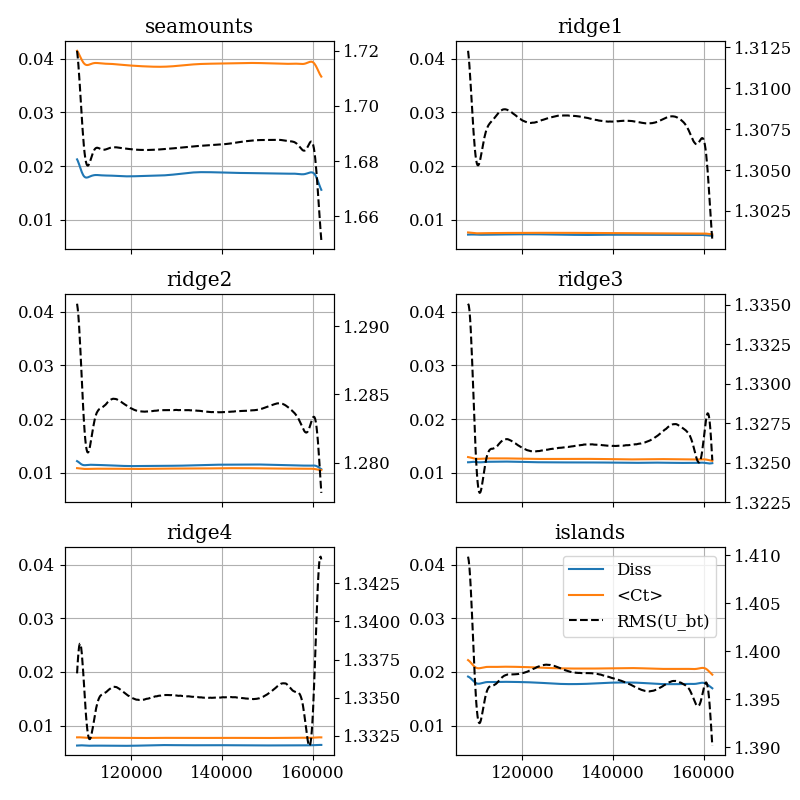

In [23]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8,8))

# conversion, dissipation
for ia in range(len(doms)):
    ax = axs.ravel()[ia]
    dom, nam = doms[ia], nams[ia]
    ax.plot(times, ress[nam]["cterm"]-ress[nam]["divf"], label="Diss")
    ax.plot(times, ress[nam]["cterm"], label="<Ct>")
    bx = ax.twinx()
    bx.plot(times, ress[nam]["Ubt"], "--k", label="RMS(U_bt)")
    ax.set_title(nam)
for ax in axs.ravel():
    ax.grid(True)
#ax.set_ylabel("Ct and Flux")
#bx.set_ylabel("U_bt")
#ax.set_xlabel('time [day]')

lina, laba = ax.get_legend_handles_labels()
linb, labb = bx.get_legend_handles_labels()
ax.legend(lina+linb, laba+labb, loc="best")

fig.set_tight_layout(True)
#fig.suptitle(simul.upper()+': time series of horizontal mean')


In [24]:
# load data (Integrated NRJ and flux, and generation/divergence/dissipation)

ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
if 'scrum_time' in ncbc.variables:
    times = ncbc.variables['scrum_time'][:]/24
else:
    times = np.arange(Nt)/24.
    
ekmean = np.nanmean(ncbc.variables['ekint_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
epmean = np.nanmean(ncbc.variables['epint_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
flmean = np.nanmean(np.sqrt((ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:]**2 \
                  + ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:]**2)), axis=(0,1))
ncbc.close()

# conversion, div flux and dissipation
# load div flux
ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
fubc = ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:]
fvbc = ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:]
ncbc.close()
divf = np.nanmean(fubc[:,-1,:] - fubc[:,0,:], axis=0)/Nx/dx + np.nanmean(fvbc[-1,:,:] - fvbc[0,:,:], axis=0)/Ny/dx

# conversion and btrop KE
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")
cterm = np.nanmean(ncbt.variables['Ct_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
ekbt = np.nanmean(np.sqrt(ncbt.variables["ekbt_lf"][j1:j2,:,:][:,i1:i2,:]*2), axis=(0,1))
ncbt.close()

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid

<IPython.core.display.Javascript object>


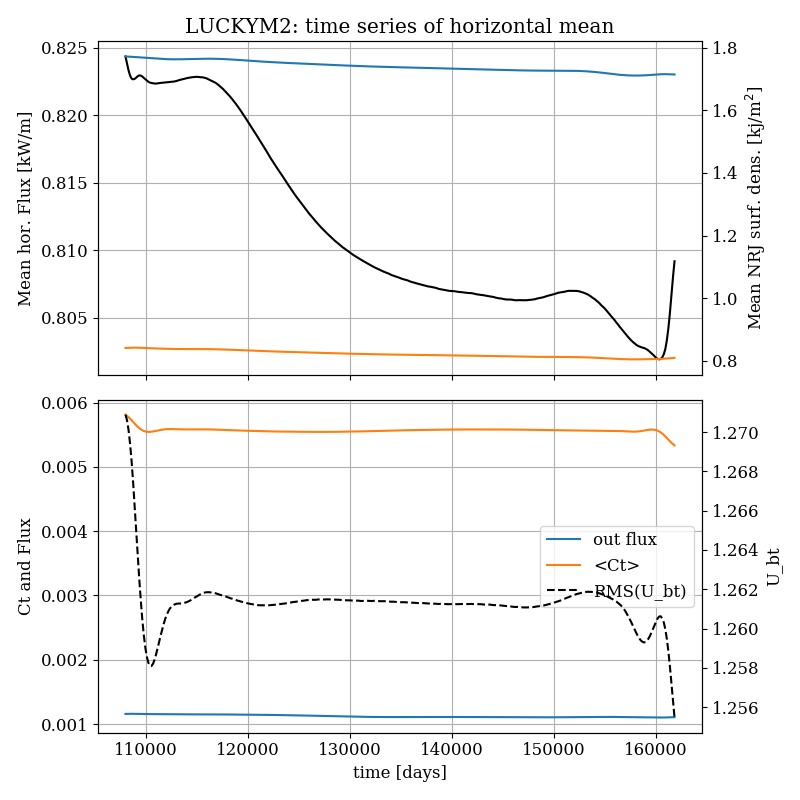

In [25]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))
# NRJ (and flux) horizontal mean
ax = axs[0]
ax.plot(times, flmean, "k", label="Flux")
ax.set_ylabel(r'Mean hor. Flux [kW/m]')

axb = plt.twinx(ax)
axb.plot(times, ekmean, label="KE")
axb.plot(times, epmean, label="PE")
axb.set_ylabel(r'Mean NRJ surf. dens. [kj/m$^2$]')

# conversion, dissipation
ax = axs[1]
ax.plot(times, divf*1e3, label="out flux")
ax.plot(times, cterm, label="<Ct>")
bx = ax.twinx()
bx.plot(times, ekbt, "--k", label="RMS(U_bt)")
ax.grid(True)
ax.set_ylabel("Ct and Flux")
bx.set_ylabel("U_bt")
ax.set_xlabel('time [day]')

lina, laba = ax.get_legend_handles_labels()
linb, labb = bx.get_legend_handles_labels()
ax.legend(lina+linb, laba+labb, loc="best")

for ax in axs:
    ax.grid(True)
ax.set_xlabel('time [days]')

axs[0].set_title(simul.upper()+': time series of horizontal mean')
fig.set_tight_layout(True)

if dosavefig:
    fig.savefig(dirpic+simul+"_MeanBclinNRJ_tseries.pdf", magnification="auto", bbox_inches="tight")